In [1]:
import torch
import torch.optim as optim
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import confusion_matrix
import seaborn
import csv

import dataset
import datasplit
import model.models as models
import trainer
import utils

In [2]:
# LOAD
# folders
models_folder = 'G:/PracaMagisterska/Kod_poglądowy/gfx-classifier_models_and_results-master/gfx-classifier_models_and_results-master/models'
model_name = '20201111_setnet_mono_disc_best'
results_folder = 'G:/PracaMagisterska/Kod_poglądowy/gfx-classifier_models_and_results-master/gfx-classifier_models_and_results-master/results'
results_subfolder = '20201111_setnet_mono_disc'

# model
fxnet = torch.load('%s/%s' % (models_folder, model_name), map_location=torch.device('cpu'))

# results
all_train_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_losses.npy')), allow_pickle=True)
all_train_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_train_correct.npy')), allow_pickle=True)
best_train_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_train_results.npy')), allow_pickle=True)

all_val_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_losses.npy')), allow_pickle=True)
all_val_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_val_correct.npy')), allow_pickle=True)
best_val_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_val_results.npy')), allow_pickle=True)

all_test_losses = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_losses.npy')), allow_pickle=True)
all_test_correct = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'all_test_correct.npy')), allow_pickle=True)
best_test_results = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'best_test_results.npy')), allow_pickle=True)

fx_labels = np.load(file=('%s/%s/%s' % (results_folder, results_subfolder, 'fx_labels.npy')), allow_pickle=True)

# datasets size
train_set_size = best_train_results.shape[0]
val_set_size = best_val_results.shape[0]
test_set_size = best_test_results.shape[0]

# example
best_train_results[0]

C:\Users\maszy\AppData\Local\Temp\ipykernel_42844\390122421.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  fxnet = torch.load('%s/%s' % (models_folder, model_name), map

array([52583, 'G91-61406-FFC-F0-21106',
       array([ 1.   ,  0.166, -0.998], dtype=float32),
       array([ 1.,  0., -1.], dtype=float32)], dtype=object)

Best Train Accuracy:  46.770313413372904
Epoch:  49

Best Val Accuracy:  41.365705614567524
Epoch:  28

Test Accuracy:  40.273562381125814
Epoch:  28



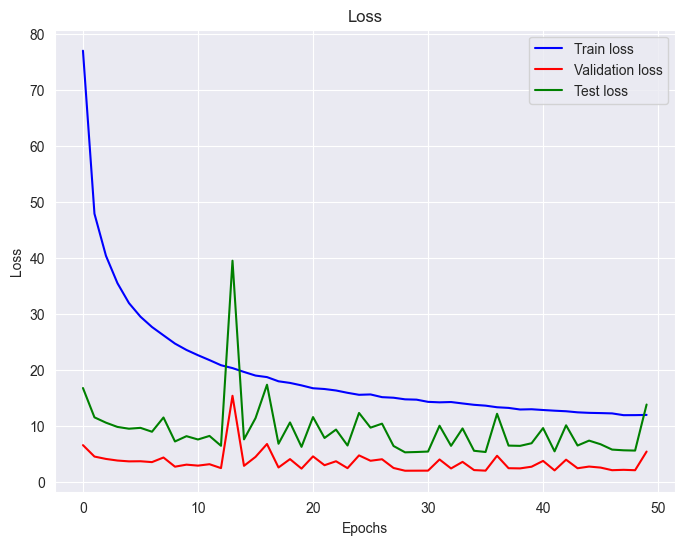

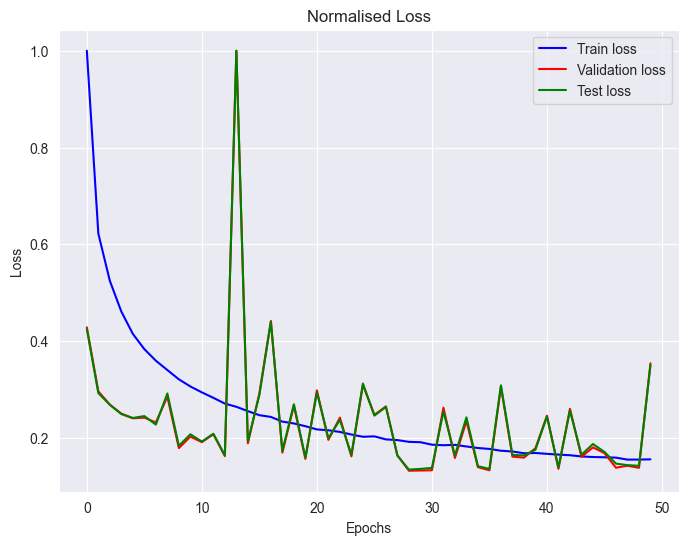

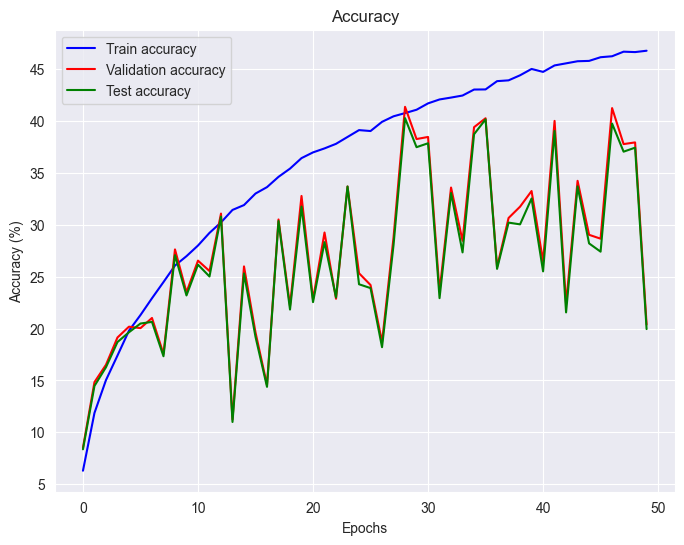

In [3]:
# Ustawienie ścieżki do zapisu
save_path = 'G:/PracaMagisterska/Kod_poglądowy/gfx-classifier_models_and_results-master/gfx-classifier_models_and_results-master/results/figures/SetNet_plots'

# BEST RESULTS
print('Best Train Accuracy: ', 100 * max(all_train_correct) / train_set_size)
print('Epoch: ', np.argmax(all_train_correct))
print()
print('Best Val Accuracy: ', 100 * max(all_val_correct) / val_set_size)
print('Epoch: ', np.argmax(all_val_correct))
print()
print('Test Accuracy: ', 100 * max(all_test_correct) / test_set_size)
print('Epoch: ', np.argmax(all_test_correct))
print()

# LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, all_train_losses, 'b', label='Train loss')
plt.plot(epochs, all_val_losses, 'r', label='Validation loss')
plt.plot(epochs, all_test_losses, 'g', label='Test loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{save_path}/loss_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

# NORMALISED LOSS
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, np.array(all_train_losses) / max(all_train_losses), 'b', label='Train loss')
plt.plot(epochs, np.array(all_val_losses) / max(all_val_losses), 'r', label='Validation loss')
plt.plot(epochs, np.array(all_test_losses) / max(all_test_losses), 'g', label='Test loss')
plt.title('Normalised Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(f'{save_path}/normalised_loss_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()

# ACCURACY
all_train_perc_correct = 100 * np.array(all_train_correct) / train_set_size
all_val_perc_correct = 100 * np.array(all_val_correct) / val_set_size
all_test_perc_correct = 100 * np.array(all_test_correct) / test_set_size
epochs = range(0, len(all_train_losses))
plt.figure(figsize=(8,6))
plt.grid(True)  # Włącza siatkę
plt.plot(epochs, all_train_perc_correct, 'b', label='Train accuracy')
plt.plot(epochs, all_val_perc_correct, 'r', label='Validation accuracy')
plt.plot(epochs, all_test_perc_correct, 'g', label='Test accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig(f'{save_path}/accuracy_plot.jpeg', format='jpeg')  # Zapisuje wykres w formacie JPEG
plt.show()